In [4]:
import MySQLdb
import time
import pandas as pd

In [359]:


# MySQL connection parameters
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': '',
    'db': 'stocks'
}

# Establish a MySQL connection
mydb = MySQLdb.connect(**db_config)
# Create a cursor object to execute SQL queries

mycursor = mydb.cursor()

# Define your SQL query
sql_query = """SELECT * FROM 
            stocks.stock_ids"""

stock_ids=pd.read_sql(sql_query,mydb)

C:\Users\hanis\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [360]:
stock_ids=stock_ids.drop('stock_ids_id',axis=1).drop_duplicates()

In [361]:
AB_Stocks=set(stock_ids[stock_ids['MF_Name']=='Aditya Birla Sun Life PSU Equity Fund']['nse_id'].values+'.BO')

In [362]:
AB_Stocks.update(['^CRSLDX','^NSEI','0P0001IV9T.BO','^SPX'])


In [805]:
import yfinance as yf
df=pd.DataFrame()
for i in AB_Stocks:
    data=yf.download(i, period="7D").reset_index()
    if i=='^CRSLDX':
        data['stock_id']='Nifty_500'
    elif i=='^NSEI':
        data['stock_id']='Nifty_50'
    elif i=='0P0001IV9T.BO':
        data['stock_id']='ABSL_MF'
    elif i=='^SPX':
        data['stock_id']='S&P500'
        
    else:
        data['stock_id']=i
    df=pd.concat([data,df])
    
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Date,Open,High,Low,Close,Adj Close,Volume,stock_id
0,2024-02-23,275.700012,280.200012,265.450012,268.899994,268.899994,1081134,BANKBARODA.BO
1,2024-02-26,269.000000,272.299988,266.700012,269.600006,269.600006,768066,BANKBARODA.BO
2,2024-02-27,269.600006,273.000000,267.399994,270.250000,270.250000,600321,BANKBARODA.BO
3,2024-02-28,270.950012,271.450012,260.799988,261.700012,261.700012,388819,BANKBARODA.BO
4,2024-02-29,261.750000,267.500000,258.350006,265.750000,265.750000,366613,BANKBARODA.BO
...,...,...,...,...,...,...,...,...
2,2024-02-27,143.899994,159.000000,143.899994,154.949997,154.949997,11171500,IREDA.BO
3,2024-02-28,157.000000,158.449997,148.100006,149.250000,149.250000,5708994,IREDA.BO
4,2024-02-29,149.300003,152.550003,141.800003,150.149994,150.149994,6867534,IREDA.BO
5,2024-03-01,154.000000,157.649994,150.600006,157.399994,157.399994,4824658,IREDA.BO


In [806]:
import pandas as pd

# Assuming your DataFrame is named df and contains columns 'Date' and 'Close'

# Step 1: Find the minimum start date among all stocks
min_start_date = df.groupby('stock_id')['Date'].min().min()

# Step 2: Find the maximum end date among all stocks
max_end_date = df.groupby('stock_id')['Date'].max().max()

# Step 3: Create a date range covering the entire period
common_date_range = pd.date_range(start=min_start_date, end=max_end_date, freq='D')

# Step 4: Reindex each stock's data to match the common date range
df_list = []
for stock_id, group_df in df.groupby('stock_id'):
    reindexed_df = group_df.set_index('Date').reindex(common_date_range).reset_index()
    reindexed_df['stock_id'] = stock_id  # Restore the 'stock_id' column
    df_list.append(reindexed_df)

# Concatenate all reindexed DataFrames back into one DataFrame
aligned_df = pd.concat(df_list, ignore_index=True)

# Now aligned_df contains all stocks with the same date range

aligned_df=aligned_df.fillna(method='ffill').fillna(method='bfill').rename(columns={'index':'Date'})

In [807]:
import matplotlib.pyplot as plt
from datetime import  datetime,timedelta


def joined_df(df,index,stock_id,interval ='M',timeline=1,initial_investment=10000):
    
    index_df = df[(df['stock_id'] == index)]
    if interval=='M':
        index_df=index_df[index_df['Date'].dt.date >=(index_df['Date'].dt.date.max()-pd.DateOffset(months=timeline)).date()]
    else:
        index_df=index_df[index_df['Date'].dt.date >=(index_df['Date'].dt.date.max()-pd.DateOffset(days=timeline)).date()]
        
    index_df['index_pct_change'] = index_df['Close'].pct_change(1)
    index_df['returns'] = (1 + index_df['index_pct_change']).cumprod() * initial_investment
    
    
    stock_df = df[(df['stock_id'] == stock_id)]
    if interval=='M':
        stock_df=stock_df[stock_df['Date'].dt.date >=(stock_df['Date'].dt.date.max()-pd.DateOffset(months=timeline)).date()]
    else:
        stock_df=stock_df[stock_df['Date'].dt.date >=(stock_df['Date'].dt.date.max()-pd.DateOffset(days=timeline)).date()]
        
    stock_df['pct_change'] = stock_df['Close'].pct_change(1)    
    stock_df['returns']= (1 + stock_df['pct_change']).cumprod() * initial_investment    
    
    ROI=pd.DataFrame(index=range(0,1))
    ROI['index']=(index_df['returns'].iloc[-1]-initial_investment)/initial_investment
    ROI['stock']=(stock_df['returns'].iloc[-1]/initial_investment)-1

    
   
    joined = pd.merge(index_df[['Date', 'index_pct_change']], stock_df[['Date', 'pct_change']], on='Date', how='inner').drop('Date', axis=1)
    joined = joined.dropna()
    
    joined.plot.scatter('index_pct_change', 'pct_change', colormap='viridis')    
    plt.show()
    
    plt.plot(joined['index_pct_change'], label=str(index))  # Use index as the label
    plt.plot(joined['pct_change'], label=str(stock_id))     # Use stock_id as the label
    plt.legend()
    plt.show()
    
    return index_df,stock_df,joined,ROI


def alpha_beta(joined):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    import numpy as np

    model=LinearRegression()

    X=joined['index_pct_change'].to_numpy().reshape(-1, 1)
    y=joined['pct_change'].to_numpy().reshape(-1, 1)

    model.fit(X,y)
    
    X_predict=np.linspace(X.min(),X.max(),50).reshape(-1, 1)
    Y_predict=model.predict(X_predict)

    y_pred = model.predict(X)
    r_squared = r2_score(y, y_pred)
    print("r_squared",r_squared)

    plt.scatter(X,y)
    plt.plot(X_predict,Y_predict)

    beta=model.coef_
    alpha=model.intercept_
    return alpha,beta

In [812]:
joined.skew()
#Analysing Skewness on Close column give risk in long term trading, whereas on pct_change gives risk in short term trading
#  Negative Skewness : you can generally expect to see a few large losses here and there as an investor.
#  +ve Skewness : As an investor, you may find that you have some small losses with a positive skew. 
#                 But you may also end up realizing large gains—albeit fewer.


index_pct_change    1.182402
pct_change         -0.042995
dtype: float64

In [814]:
joined.kurtosis()
# = 3.0 means moderate risk
# > 3.0 means high risk but chances of high returns
# < 3.0 means low risk

index_pct_change    1.801984
pct_change          3.310847
dtype: float64

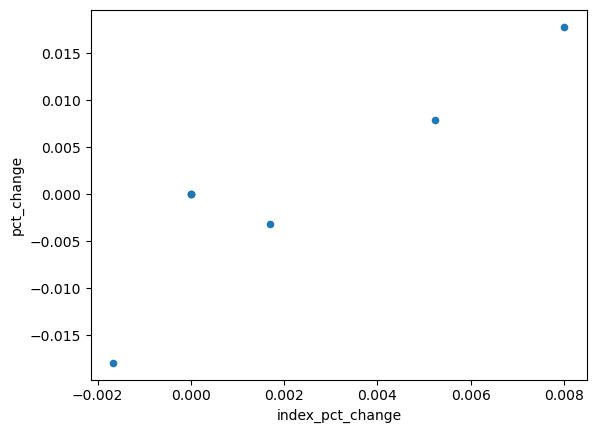

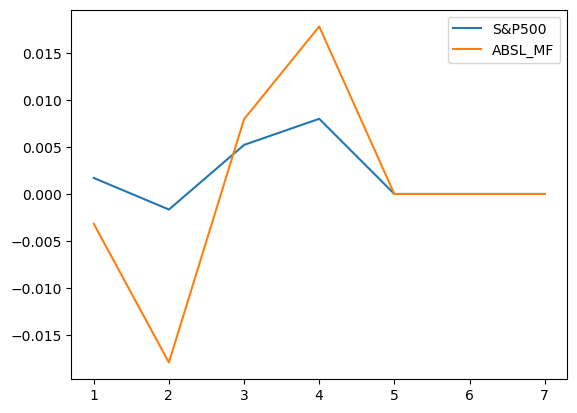

r_squared 0.7821922409953074


(array([-0.00461036]), array([[2.78135076]]))

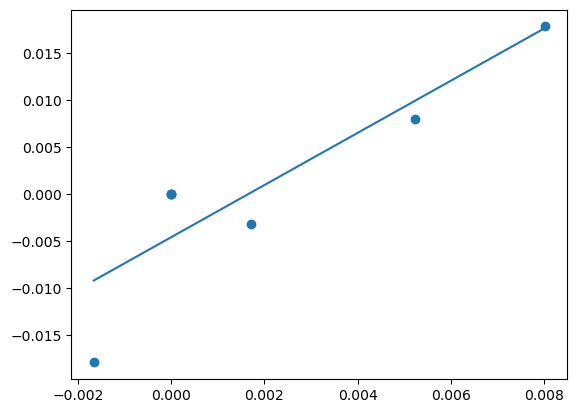

In [815]:
index_df,stock_df,joined,ROI=joined_df(aligned_df,'S&P500','ABSL_MF',interval='D',timeline=7,initial_investment=100000)
alpha_beta(joined)
# Alpha measures returns performance of a stock.An alpha of -15 means the investment was far too risky given the return.
# Alpha=0 suggests that an asset has earned a return commensurate with the risk. 
# Alpha>0 means an investment outperformed, after adjusting for volatility.

# Beta measures the volatility of a stock compared to the benchmark

C:\Users\hanis\AppData\Local\Temp\ipykernel_36792\705991357.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['percent_change']=(df1['Close'].diff()/df1['Close'].shift())
C:\Users\hanis\AppData\Local\Temp\ipykernel_36792\705991357.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['SMA_12'] = ta.trend.sma_indicator(close=df1['Close'], window=12)
C:\Users\hanis\AppData\Local\Temp\ipykernel_36792\705991357.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

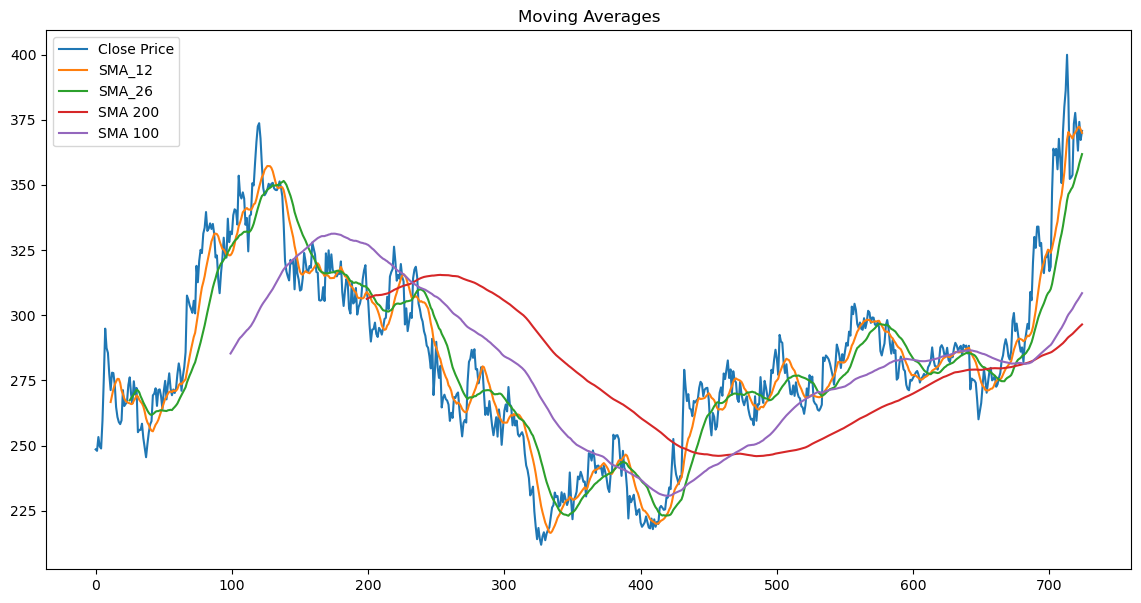

In [156]:
import pandas as pd
import ta

df1=df[df['stock_id']=='GSPL.BO']
df1['percent_change']=(df1['Close'].diff()/df1['Close'].shift())

# Calculate Moving Averages
df1['SMA_12'] = ta.trend.sma_indicator(close=df1['Close'], window=12)
df1['SMA_26'] = ta.trend.sma_indicator(close=df1['Close'], window=26)
df1['SMA_200'] = ta.trend.sma_indicator(close=df1['Close'], window=200)
df1['SMA_100'] = ta.trend.sma_indicator(close=df1['Close'], window=100)


# Calculate RSI
df1['RSI'] = ta.momentum.rsi(close=df1['Close'], window=14)

# Calculate MACD
df1['MACD'] = ta.trend.macd_diff(close=df1['Close'], window_slow=26, window_fast=12)

# Calculate Volume Analysis
df1['Volume_SMA_20'] = ta.trend.sma_indicator(close=df1['Volume'], window=20)

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot((df1['Close']), label='Close Price')
# plt.plot(Nifty_500['percent_change'],label='Nifty500')
plt.plot(df1['SMA_12'].dropna(), label='SMA_12')
plt.plot(df1['SMA_26'].dropna(), label='SMA_26')
plt.plot(df1['SMA_200'].dropna(), label='SMA 200')
plt.plot(df1['SMA_100'].dropna(), label='SMA 100')
plt.legend()

plt.title('Moving Averages')
plt.show()


In [405]:
df1['RSI_Trigger']=np.where(df1['RSI']>70,-1,np.where(df1['RSI']<30,1,0))
df1['ST_26_12']=np.where(df1['SMA_12']>=df1['SMA_26'],1,-1)
df1['LT_100_200']=np.where(df1['SMA_100']>=df1['SMA_200'],1,-1)

C:\Users\hanis\AppData\Local\Temp\ipykernel_20228\851961710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['RSI_Trigger']=np.where(df1['RSI']>70,-1,np.where(df1['RSI']<30,1,0))
C:\Users\hanis\AppData\Local\Temp\ipykernel_20228\851961710.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ST_26_12']=np.where(df1['SMA_12']>=df1['SMA_26'],1,-1)
C:\Users\hanis\AppData\Local\Temp\ipykernel_20228\851961710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [155]:
df1

,Date,Open,High,Low,Close,Adj Close,Volume,stock_id,percent_change,SMA_12,SMA_26,SMA_200,SMA_100,RSI,MACD,Volume_SMA_20
0,2021-02-23,243.000000,251.399994,233.600006,248.500000,241.988602,63669,GSPL.BO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-24,251.800003,251.800003,244.000000,247.949997,241.453003,170321,GSPL.BO,-0.002213,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-25,248.000000,255.500000,245.750000,253.250000,246.614136,47974,GSPL.BO,0.021375,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-02-26,249.250000,255.300003,247.250000,249.600006,243.059784,22916,GSPL.BO,-0.014413,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-03-01,259.000000,259.000000,246.649994,248.850006,242.329437,53754,GSPL.BO,-0.003005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,2024-02-19,383.850006,383.850006,368.450012,371.250000,371.250000,75525,GSPL.BO,-0.016947,370.987501,354.276925,294.496248,305.158499,56.901622,-1.964498,208099.45
721,2024-02-20,374.600006,374.600006,360.250000,363.149994,363.149994,75033,GSPL.BO,-0.021818,372.024999,355.998079,294.984249,305.904999,53.340157,-2.540552,210406.40
722,2024-02-21,365.450012,377.000000,362.450012,374.200012,374.200012,78671,GSPL.BO,0.030428,372.341667,358.230772,295.495749,306.773499,57.269371,-2.183816,195645.75
723,2024-02-22,376.350006,376.899994,365.000000,367.250000,367.250000,82691,GSPL.BO,-0.018573,371.287501,359.975003,295.987499,307.598999,54.179067,-2.404869,194384.25


In [478]:
data=df1[['Close','Volume','ST_26_12','LT_100_200','RSI_Trigger']]

In [413]:
# for i in range(1, 11):
#     data[f'Close_{i}'] = data['Close'].shift(i)
    
    

C:\Users\hanis\AppData\Local\Temp\ipykernel_20228\1537389758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Close_{i}'] = data['Close'].shift(i)
C:\Users\hanis\AppData\Local\Temp\ipykernel_20228\1537389758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Close_{i}'] = data['Close'].shift(i)
C:\Users\hanis\AppData\Local\Temp\ipykernel_20228\1537389758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [414]:
data

,Close,Volume,ST_26_12,LT_100_200,RSI_Trigger,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Close_8,Close_9,Close_10
0,243.000000,69983.0,-1,-1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,248.500000,63669.0,-1,-1,0,243.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,247.949997,170321.0,-1,-1,0,248.500000,243.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,253.250000,47974.0,-1,-1,0,247.949997,248.500000,243.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,249.600006,22916.0,-1,-1,0,253.250000,247.949997,248.500000,243.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,373.450012,178756.0,1,1,0,353.850006,352.850006,352.299988,383.299988,399.950012,386.250000,379.899994,370.399994,350.700012,360.450012
720,377.649994,317352.0,1,1,0,373.450012,353.850006,352.850006,352.299988,383.299988,399.950012,386.250000,379.899994,370.399994,350.700012
721,371.250000,75525.0,1,1,0,377.649994,373.450012,353.850006,352.850006,352.299988,383.299988,399.950012,386.250000,379.899994,370.399994
722,363.149994,75033.0,1,1,0,371.250000,377.649994,373.450012,353.850006,352.850006,352.299988,383.299988,399.950012,386.250000,379.899994


In [479]:
# Amount_invested = 10000
# Invested_11thday=Amount_invested/data['Close'][0]
data['percent_change']=(data['Close'].diff()/data['Close'].shift())

for i in range(1, 11):
    data[f'percent_change_{i}'] = data['percent_change'].shift(i)
    
    
data=data.dropna(how='any').reset_index(drop=True)



C:\Users\hanis\AppData\Local\Temp\ipykernel_20228\2717086259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['percent_change']=(data['Close'].diff()/data['Close'].shift())
C:\Users\hanis\AppData\Local\Temp\ipykernel_20228\2717086259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'percent_change_{i}'] = data['percent_change'].shift(i)
C:\Users\hanis\AppData\Local\Temp\ipykernel_20228\2717086259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

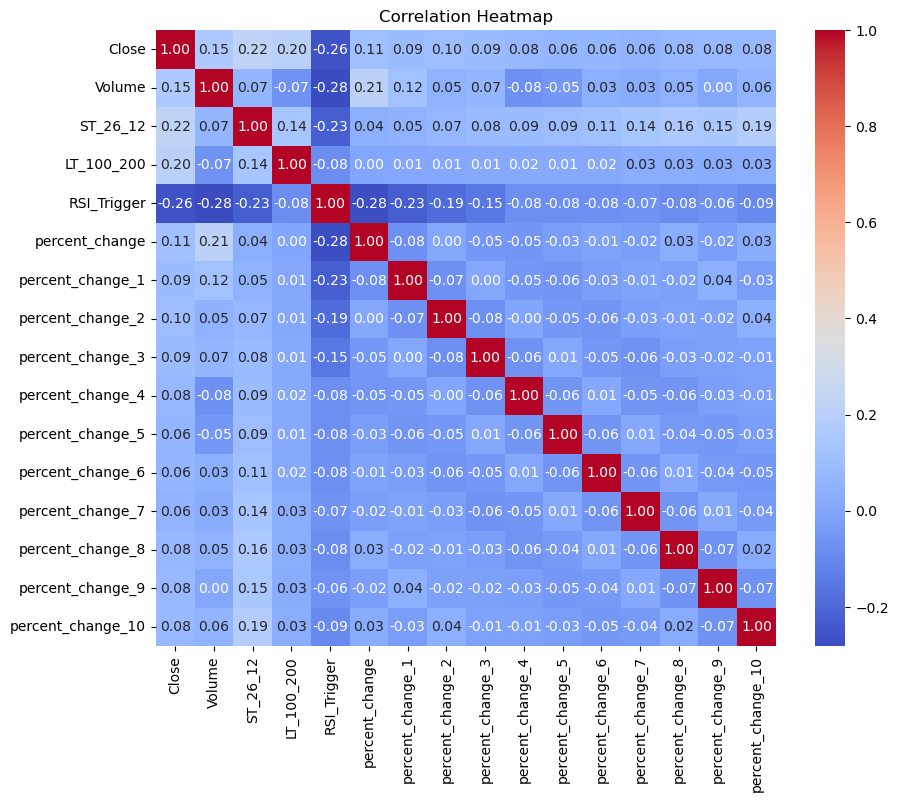

In [480]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
corr_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [481]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(['Close','Volume','percent_change'],axis=1), data['percent_change'], test_size=0.3, random_state=42)

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [482]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import numpy as np
# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Print the coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error: 0.00031792910674535154
Coefficients: [ 0.0013774  -0.00048934 -0.07812418 -0.04203898 -0.02201454 -0.02657674
 -0.01359928 -0.01844684 -0.0162485  -0.01266924 -0.00961016 -0.01004143
 -0.00029669]
Intercept: 0.11621253560303914
Mean Absolute Error (MAE): 0.01385628860794746
Root Mean Squared Error (RMSE): 0.017830566641174127


In [483]:
# Predict on training and testing set
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate mean squared error
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)

Training MSE: 0.00039355918729105466
Testing MSE: 0.00031792910674535154


In [484]:
data['percent_change'].iloc[712]*100

3.0428248647297718

In [487]:
data

,Close,Volume,ST_26_12,LT_100_200,RSI_Trigger,percent_change,percent_change_1,percent_change_2,percent_change_3,percent_change_4,percent_change_5,percent_change_6,percent_change_7,percent_change_8,percent_change_9,percent_change_10
0,277.350006,40266.0,-1,-1,0,-0.028716,-0.006437,-0.025267,0.067910,0.063969,0.042797,-0.003005,-0.014413,0.021375,-0.002213,0.022634
1,271.250000,40689.0,-1,-1,0,-0.021994,-0.028716,-0.006437,-0.025267,0.067910,0.063969,0.042797,-0.003005,-0.014413,0.021375,-0.002213
2,277.950012,98896.0,-1,-1,0,0.024701,-0.021994,-0.028716,-0.006437,-0.025267,0.067910,0.063969,0.042797,-0.003005,-0.014413,0.021375
3,277.799988,79165.0,-1,-1,0,-0.000540,0.024701,-0.021994,-0.028716,-0.006437,-0.025267,0.067910,0.063969,0.042797,-0.003005,-0.014413
4,273.500000,36912.0,-1,-1,0,-0.015479,-0.000540,0.024701,-0.021994,-0.028716,-0.006437,-0.025267,0.067910,0.063969,0.042797,-0.003005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,373.450012,178756.0,1,1,0,0.055391,0.002834,0.001561,-0.080877,-0.041630,0.035469,0.016715,0.025648,0.056173,-0.027050,-0.019717
709,377.649994,317352.0,1,1,0,0.011246,0.055391,0.002834,0.001561,-0.080877,-0.041630,0.035469,0.016715,0.025648,0.056173,-0.027050
710,371.250000,75525.0,1,1,0,-0.016947,0.011246,0.055391,0.002834,0.001561,-0.080877,-0.041630,0.035469,0.016715,0.025648,0.056173
711,363.149994,75033.0,1,1,0,-0.021818,-0.016947,0.011246,0.055391,0.002834,0.001561,-0.080877,-0.041630,0.035469,0.016715,0.025648


In [489]:
todays_scaled=scaler.transform(data.drop(['Close','Volume','percent_change'],axis=1).iloc[712].values.reshape(1, -1))

C:\Users\hanis\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [492]:
model.predict(todays_scaled)*100

array([0.78159253])

In [465]:
dummy=pd.concat([pd.DataFrame(y_pred),y_test.reset_index(drop=True)], axis=1)
dummy.columns=['pred','true']
(dummy['true']-dummy['pred']).describe()

count    215.000000
mean       0.001625
std        0.019675
min       -0.073396
25%       -0.008623
50%        0.000952
75%        0.012501
max        0.068620
dtype: float64

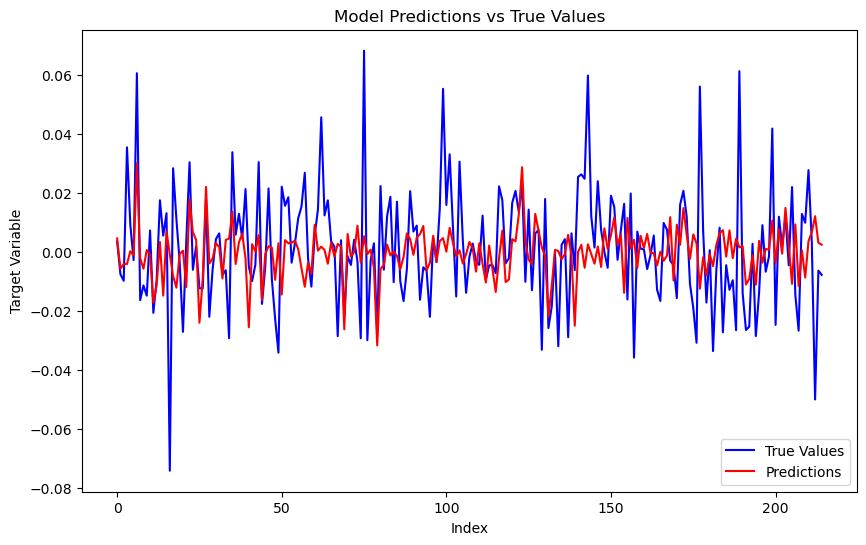

In [467]:
import matplotlib.pyplot as plt

# Assuming y_pred contains model predictions and y_true contains true values
# Replace y_pred and y_true with your actual variables

plt.figure(figsize=(10, 6))

# Plotting true values
plt.plot(y_test.to_numpy(), label='True Values', color='blue')

# Plotting model predictions
plt.plot(y_pred, label='Predictions', color='red')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Target Variable')
plt.title('Model Predictions vs True Values')
plt.legend()

# Display the plot
plt.show()


In [ ]:
model.predict(X_test_scaled)

In [361]:
# Mean Squared Error: 37.86385836315275
# Epoch 50/50
# 16/16 [==============================] - 0s 16ms/step - loss: 1886.0641
# Using Percent change as target
Mean Squared Error: 0.0003313879629401903
Coefficients: [ 0.06193543  0.00141442  0.00115283 -0.05566481 -0.13399858  0.06214124
 -0.03950235  0.0151216   0.05071761 -0.0029001  -0.0140312   0.03577896
 -0.00064359  0.01263177]
Intercept: 0.02911298055198784
Mean Absolute Error (MAE): 0.013897456924211654
Root Mean Squared Error (RMSE): 0.018204064462097203
#using Close with Percent_change
Mean Squared Error: 0.5099388624822037
Coefficients: [ 2.94235250e-01 -2.68785286e-03  1.20498955e-03 -3.65899698e-01
  1.89152630e+02 -2.23642741e+00 -1.69282387e+00 -1.17132798e+00
  3.12740972e+00  2.77986688e+00 -4.13455402e+00  2.44794266e+00
 -1.38061302e-01 -1.54282199e-01  5.03286133e+01]
Intercept: 189.07977589066493
Mean Absolute Error (MAE): 0.48536144215062405
Root Mean Squared Error (RMSE): 0.7141000367470959

399.95001220703125

In [447]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout

model=Sequential()
model.add(LSTM(units=50,activation='relu',return_sequences=True,input_shape=(X_train_scaled.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu',return_sequences=True))
model.add(Dropout(0.5))

model.add(Dense(units=1))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 13, 50)            10400     
                                                                 
 dropout_44 (Dropout)        (None, 13, 50)            0         
                                                                 
 lstm_48 (LSTM)              (None, 13, 60)            26640     
                                                                 
 dropout_45 (Dropout)        (None, 13, 60)            0         
                                                                 
 lstm_49 (LSTM)              (None, 13, 80)            45120     
                                                                 
 dropout_46 (Dropout)        (None, 13, 80)            0         
                                                                 
 lstm_50 (LSTM)              (None, 13, 120)         

In [448]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_scaled,y_train,epochs=50) 

Epoch 1/50
16/16 [==============================] - 3s 15ms/step - loss: 4.4652e-04
Epoch 2/50
16/16 [==============================] - 0s 17ms/step - loss: 4.4282e-04
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 4.3944e-04
Epoch 4/50
16/16 [==============================] - 0s 18ms/step - loss: 4.3978e-04
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 4.4721e-04
Epoch 6/50
16/16 [==============================] - 0s 17ms/step - loss: 4.4286e-04
Epoch 7/50
16/16 [==============================] - 0s 18ms/step - loss: 4.3757e-04
Epoch 8/50
16/16 [==============================] - 0s 17ms/step - loss: 4.3967e-04
Epoch 9/50
16/16 [==============================] - 0s 17ms/step - loss: 4.3792e-04
Epoch 10/50
16/16 [==============================] - 0s 17ms/step - loss: 4.3838e-04
Epoch 11/50
16/16 [==============================] - 0s 16ms/step - loss: 4.3946e-04
Epoch 12/50
16/16 [==============================] - 0s 17ms/step - loss: 

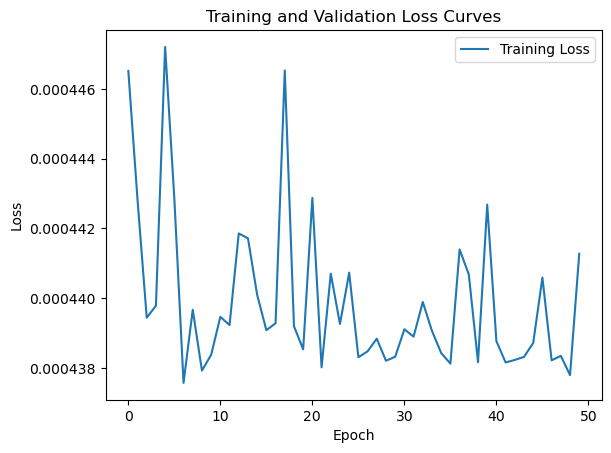

In [449]:
import matplotlib.pyplot as plt

# Retrieve training history
history = model.history.history

# Plot training and validation loss curves
plt.plot(history['loss'], label='Training Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
#Standarscale

In [170]:
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()

scale.fit_transform(data)

array([[-0.97378773, -0.02472843, -0.95270757, -0.79965979,  0.04832095],
       [-1.13960567,  0.06863134, -0.95270757, -0.79965979,  0.04832095],
       [-0.98099721,  0.00997725, -0.95270757, -0.79965979,  0.04832095],
       ...,
       [ 2.62229899,  1.07908139,  1.04964003,  1.2505318 ,  0.04832095],
       [ 2.74341765,  2.3665731 ,  1.04964003,  1.2505318 ,  0.04832095],
       [ 2.55885526,  0.12011392,  1.04964003,  1.2505318 ,  0.04832095]])